# Tutorial 2: analyzing StreamSBI
In this tutorial, we will walk through how to analyze the input and output of SBI model by examples, in particular making plots of streams and posteriors.

In [2]:
%cd sbi_stream
%load_ext autoreload
%autoreload 2

import os
import pickle
import sys
sys.path.append('..')  # add sbi_stream parent directory to path
import corner
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl

from tqdm import tqdm
from scipy.interpolate import LSQUnivariateSpline

import datasets
from models import regressor, infer_utils
from datasets import io_utils, preprocess_utils

%matplotlib inline

[Errno 2] No such file or directory: 'sbi_stream'
/global/u2/r/rutong/sbi_stream
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/global/u2/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Analyze the input streams

In order to get particle and binned simulation data, we first specify the dataset we are using, and labels associated with the run. Specifically we cut `phi1` range to be `[-20, 12]`

In [3]:
#get particle and binned simulation data
data_name = '/2params-n1000'
raw_data_dir = f'/pscratch/sd/t/tvnguyen/stream_sbi/datasets/{data_name}'
data_labels = ['log_M_sat', 'vz']
num_bins = 50 #use 10 to 50
phi1_min = -20
phi1_max = 12

This code block reads the raw simulation data from a given directory, which contain `phi1, phi2, pm1, pm2, vr, distance` of each particle. You can index into different streams. For example, `raw[0]` will return the first stream in this dataset (`raw[0].shape` = 6 * #particles in stream) and `raw[0][1]` will return `phi2` of all particles.

In [24]:
def read_raw_dataset(data_dir, labels, num_datasets=1):
    """ Read raw data

    Parameters
    ----------
    data_dir : str
        Path to the directory containing the stream data.
    labels : list of str
        List of labels to use for the regression.
    num_datasets : int, optional
        Number of datasets to read in. Default is 1.
    """

    raw = []

    for i in range(num_datasets):
        label_fn = os.path.join(data_dir, f'labels.{i}.csv')
        data_fn = os.path.join(data_dir, f'data.{i}.hdf5')

        if os.path.exists(label_fn) & os.path.exists(data_fn):
            print('Reading in data from {}'.format(data_fn))
        else:
            print('Dataset {} not found. Skipping...'.format(i))
            continue

        # read in the data and label
        table = pd.read_csv(label_fn)
        data, ptr = io_utils.read_dataset(data_fn, unpack=True)

        # compute some derived labels
        table = datasets.calculate_derived_properties(table)

        loop = tqdm(range(len(table)))

        for pid in loop:
            loop.set_description(f'Processing pid {pid}')
            phi1 = data['phi1'][pid]
            phi2 = data['phi2'][pid]
            pm1 = data['pm1'][pid]
            pm2 = data['pm2'][pid]
            vr = data['vr'][pid]
            dist = data['dist'][pid]

            raw.append(np.stack([phi1, phi2, pm1, pm2, vr, dist]))

    return raw

Now we can get the raw data and binned data.


```
'x: (binned data) phi2, pm1, pm2, vr, distance'
't: (binned data) phi1'
```



In [25]:
raw = read_raw_dataset(raw_data_dir, data_labels)

Reading in data from /pscratch/sd/t/tvnguyen/stream_sbi/datasets//2params-n1000/data.0.hdf5


Processing pid 2984:  33%|█████████████▍                           | 2896/8800 [00:01<00:02, 2176.46it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing pid 8799: 100%|█████████████████████████████████████████| 8800/8800 [00:04<00:00, 2108.45it/s]


In [15]:
len(raw)

8800

In [6]:
x, y, t, padding_mask = datasets.read_process_dataset(raw_data_dir, data_labels, phi1_min=phi1_min, phi1_max=phi1_max, num_knots=50, frac=True)

Reading in data from /pscratch/sd/t/tvnguyen/stream_sbi/datasets//2params-n1000/data.0.hdf5


Processing pid 8799: 100%|████████████████████████████████████████████████████████| 8800/8800 [02:34<00:00, 56.89it/s]


We can change the index number to analyze different streams. Here we pick `stream 512 `as an example.

In [26]:
index = 512

'particle'
r_phi1 = raw[index][0]
r_phi2 = raw[index][1]
r_pm1 = raw[index][2]
r_pm2 = raw[index][3]
r_vr = raw[index][4]
r_dist = raw[index][5]

'binned'
phi1s = t[index]

phi2s = x[index][:,0]
pm1s = x[index][:,1]
pm2s = x[index][:,2]
vrs = x[index][:,3]
dist = x[index][:,4]

phi2_std = x[index][:,5]
pm1_std = x[index][:,6]
pm2_std = x[index][:,7]
vr_std = x[index][:,8]
dist_std = x[index][:,9]

# fraction = x[index][:, 10]

'filter out empty bins'
mask = phi2_std != 0

phi1s = phi1s[mask]

phi2s = phi2s[mask]
pm1s = pm1s[mask]
pm2s = pm2s[mask]
vrs = vrs[mask]
dist = dist[mask]

phi2_std = phi2_std[mask]
pm1_std = pm1_std[mask]
pm2_std = pm2_std[mask]
vr_std = vr_std[mask]
dist_std = dist_std[mask]

# fraction = fraction[mask]

'filter out out-of-range bins, and sort by phi1 values'
'These are useful for calculating spline fit'
mask2 = (r_phi1 >= phi1_min) & (r_phi1 <= phi1_max)
sorted_phi1 = r_phi1[mask2]
sorted_phi2 = r_phi2[mask2]
sorted_pm1 = r_pm1[mask2]
sorted_pm2 = r_pm2[mask2]
sorted_vr = r_vr[mask2]
sorted_dist = r_dist[mask2]

sorted_indices = np.argsort(sorted_phi1)
sorted_phi1 = sorted_phi1[sorted_indices]
sorted_phi2 = sorted_phi2[sorted_indices]
sorted_pm1 = sorted_pm1[sorted_indices]
sorted_pm2 = sorted_pm2[sorted_indices]
sorted_vr = sorted_vr[sorted_indices]
sorted_dist = sorted_dist[sorted_indices]

### **example**: analyze phi1 vs phi2

We calculate the spline fit for `phi1` vs `phi2`. `knots` is a list of locations for internal knots of spline. We pick `bin_centers` as locations for `knots` ***excluding some first and last bins*** (sometimes they happen to violate the *Schoenberg-Whitney Conditions* required for `LSQUnivariateSpline`)

In [27]:
xy = np.transpose(np.vstack((sorted_phi1, sorted_phi2)))
knots = np.sort(phi1s[:, 0])
knots = knots[1:-1]
splined = LSQUnivariateSpline(sorted_phi1, sorted_phi2, knots)
y_splined = splined(sorted_phi1)

We now can visualize this stream, with particles, bin data, and spline fit. Notice that `splined` is a function that takes in as list of `x_coordinate` and spits out the predicted `y_coordinate` on spline.

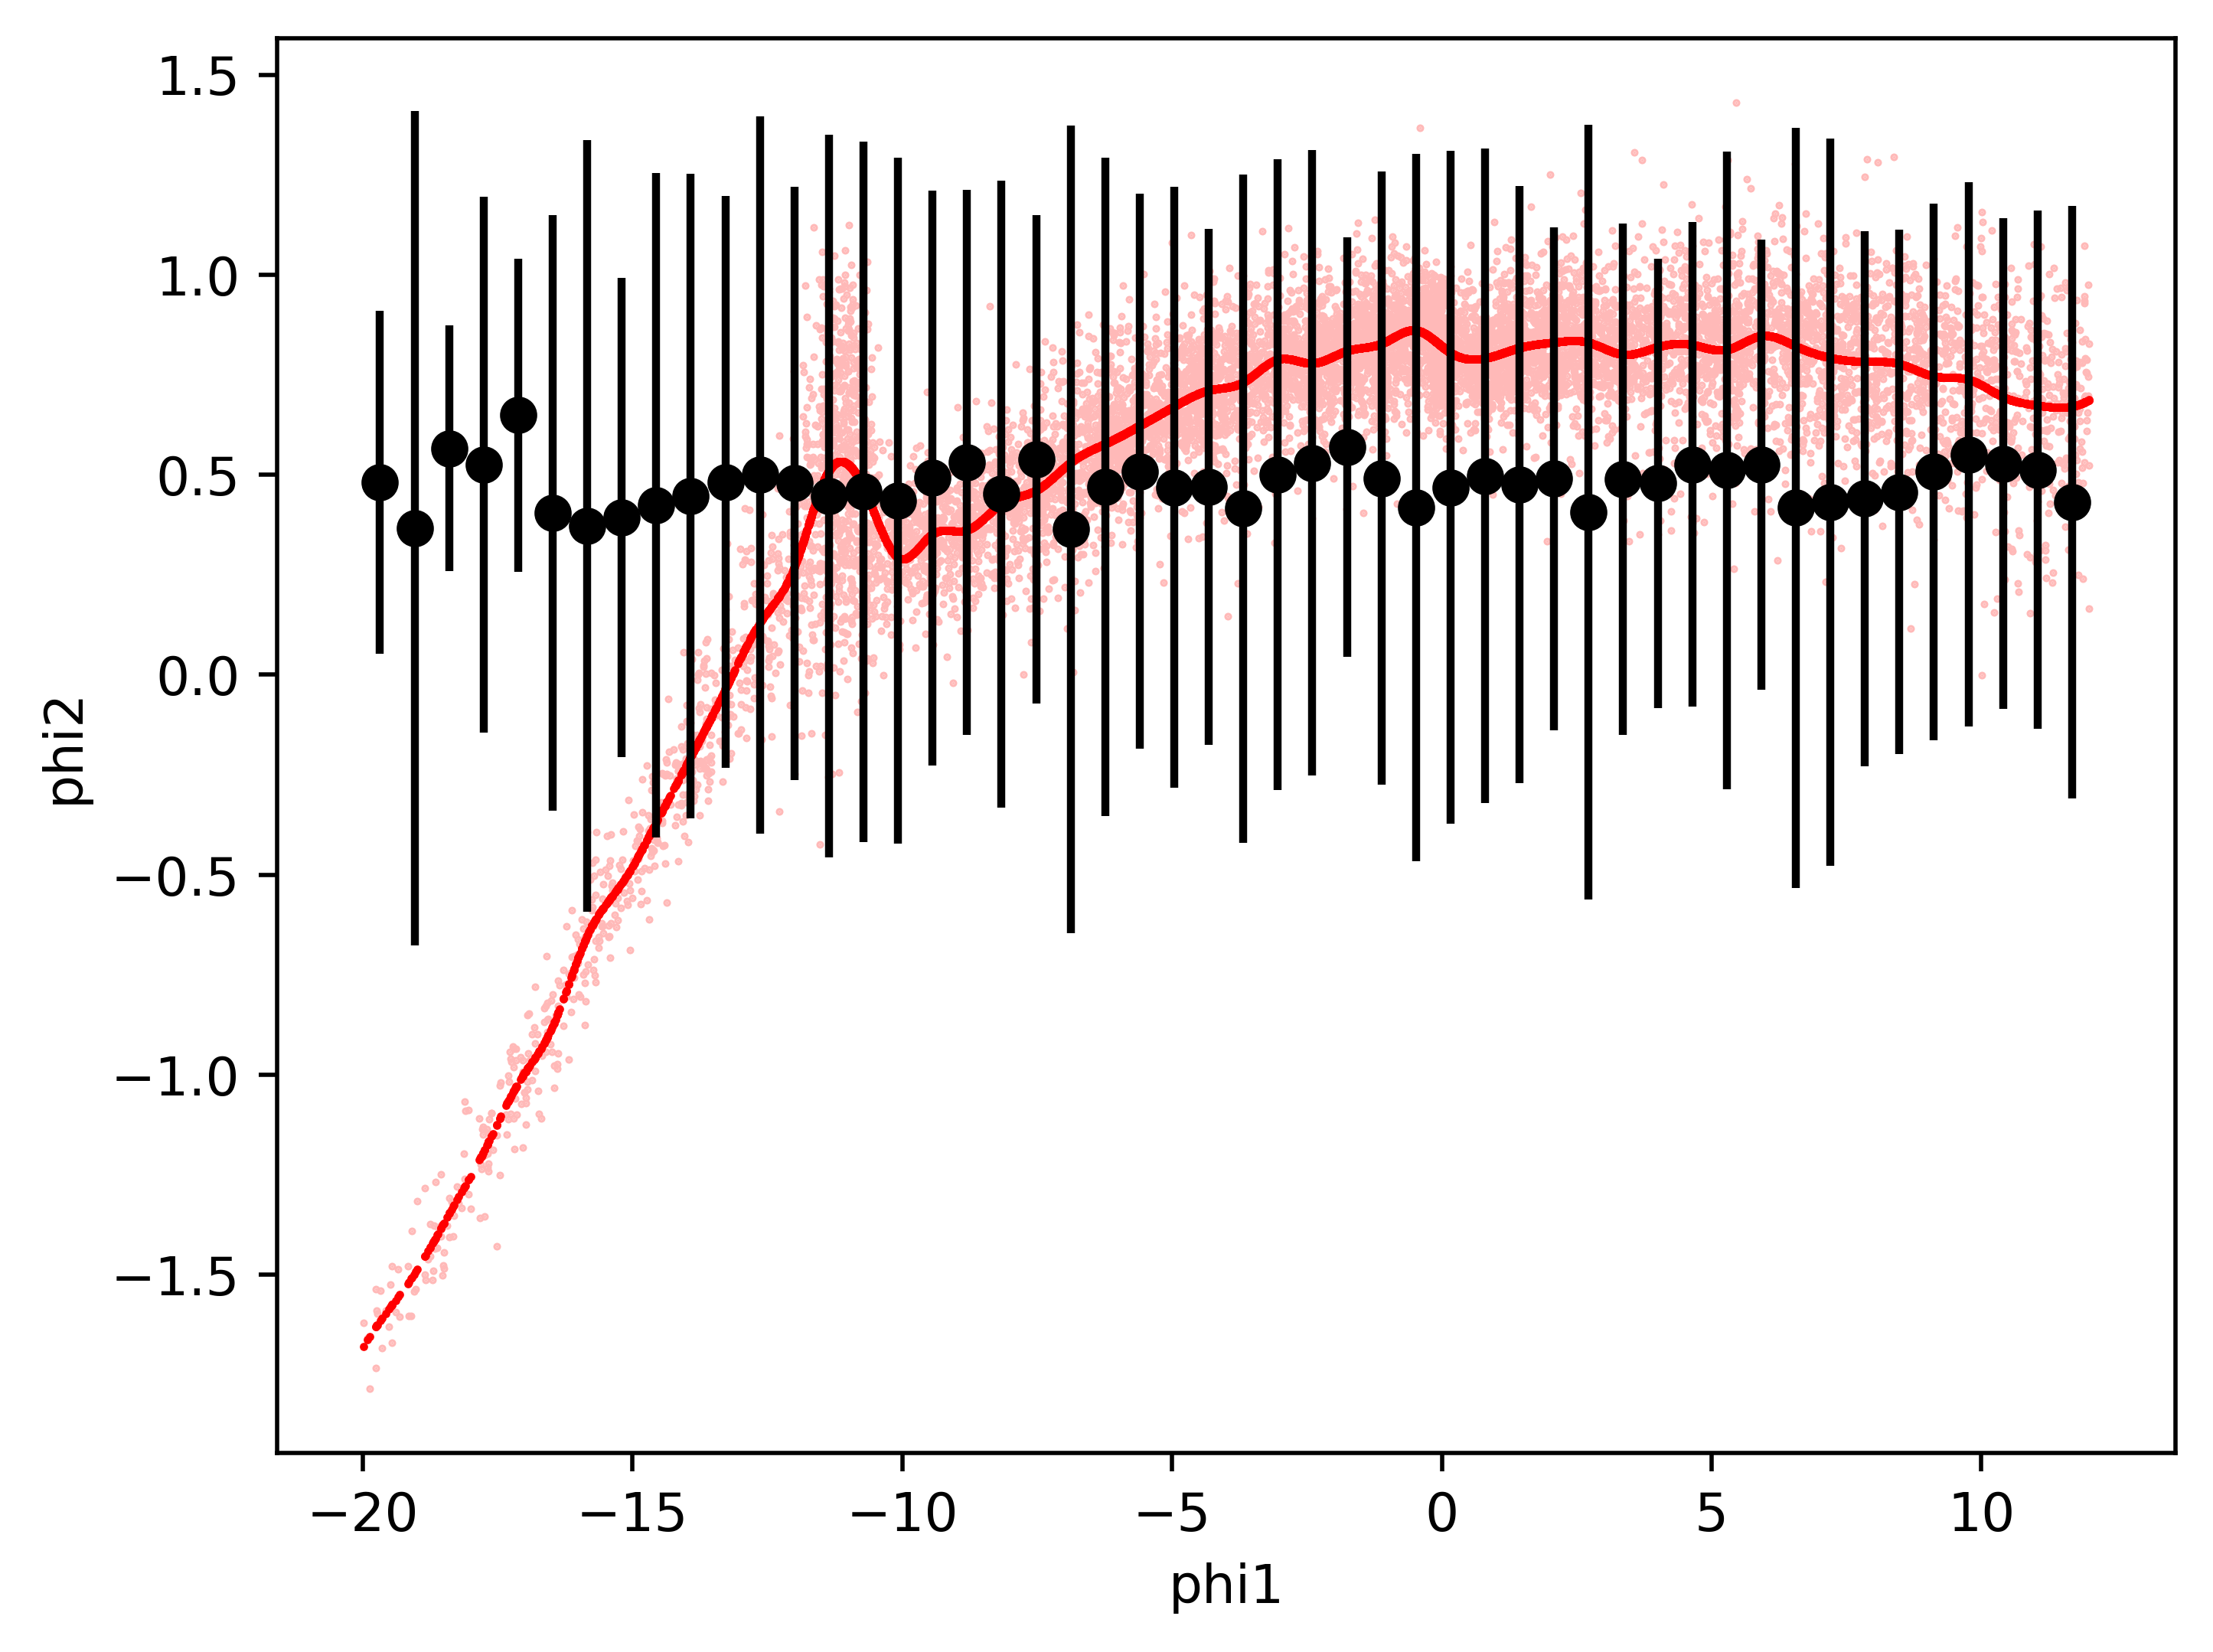

In [29]:
'plot stream'
plt.xlabel('phi1')
plt.ylabel('phi2')

#plot bin
plt.errorbar(phi1s, phi2s, yerr=phi2_std, color='black',fmt='o', ecolor='black')

#plot particle
plt.scatter(sorted_phi1, sorted_phi2, color='#FFB9B8', s=0.2)

#plot spline
plt.scatter(sorted_phi1, splined(sorted_phi1), color='red', s=0.3)

We also want to analyze how much the stream particles parameter values deviate from the spline fit, along the `phi1` coordinate. Here we pick number of bins to be 20.

Text(0, 0.5, '$\\Delta \\phi_{2}$')

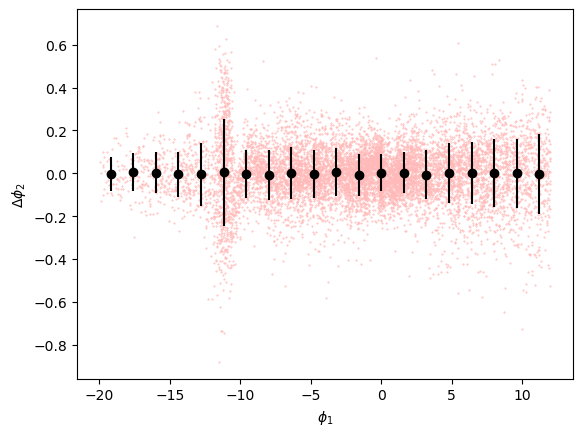

In [10]:
'plot deviation from spline'
y_diff = sorted_phi2 - y_splined
spline_mean, bin_edges, _ = stats.binned_statistic(sorted_phi1, y_diff, statistic='mean', bins=20)
spline_std, _, _ = stats.binned_statistic(sorted_phi1, y_diff, statistic='std', bins=20)
spline_count, _, _= stats.binned_statistic(sorted_phi1, y_diff, statistic='count', bins=20)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.errorbar(bin_centers, spline_mean, yerr=spline_std, color='black',fmt='o', ecolor='black')
plt.scatter(sorted_phi1, y_diff, color='#FFB9B8', s=0.2)
plt.xlabel(r'$\phi_{1}$')
plt.ylabel(r'$\Delta \phi_{2}$')

# Analyze the output
in general, we want to make the following plots:

1. corner plot
2. coverage plot for the posteriors
3. predicted posteriors vs. truths

### **example**: msat, vz

First we need to pick which regression model we want to analyze. `run_name` and its detailed info are kept in this [google sheet](https://docs.google.com/spreadsheets/d/1R_vq7Ol2kOJ5HsCiQlfRdyKBZtF_8E-PQdUIktq2foM/edit?usp=sharing). Note that `seed` may vary depending on the run.

In [10]:
#get trained model
checkpoint_root = '/pscratch/sd/r/rutong/logging/'
run_name = 'heavy-rod-19'

checkpoint_path = f"{checkpoint_root}" \
    f"{run_name}/lightning_logs/checkpoints/epoch=825-step=45430.ckpt"

model = regressor.Regressor.load_from_checkpoint(checkpoint_path)

seed = 11
pl.seed_everything(seed)

# read in the dataset and prepare the data loader for training
data_root = '/pscratch/sd/r/rutong/stream_sbi/datasets/2params-n1000'
data_name = '/2params-n1000'
data_processed_path = os.path.join(data_root, f"processed/{run_name}.pkl")

with open(data_processed_path, "rb") as f:
    data = pickle.load(f)

train_loader, val_loader, norm_dict = datasets.prepare_dataloader(
    data, train_frac=0.8, train_batch_size=1024, eval_batch_size=128,
    num_workers=4, seed=seed
)

/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[rank: 0] Seed set to 11
[rank: 0] Seed set to 11


Here we draw `5000` samples from this model.
`labels` indicate which parameters we used for regression.

In [14]:
samples, labels = infer_utils.sample(model, val_loader, 5000, norm_dict=norm_dict)

Sampling: 100%|██████████████████████████████████████████████████████████| 14/14 [00:23<00:00,  1.68s/it]


In [13]:
print(samples.shape)

(1760, 5000, 2)


In [22]:
index=218

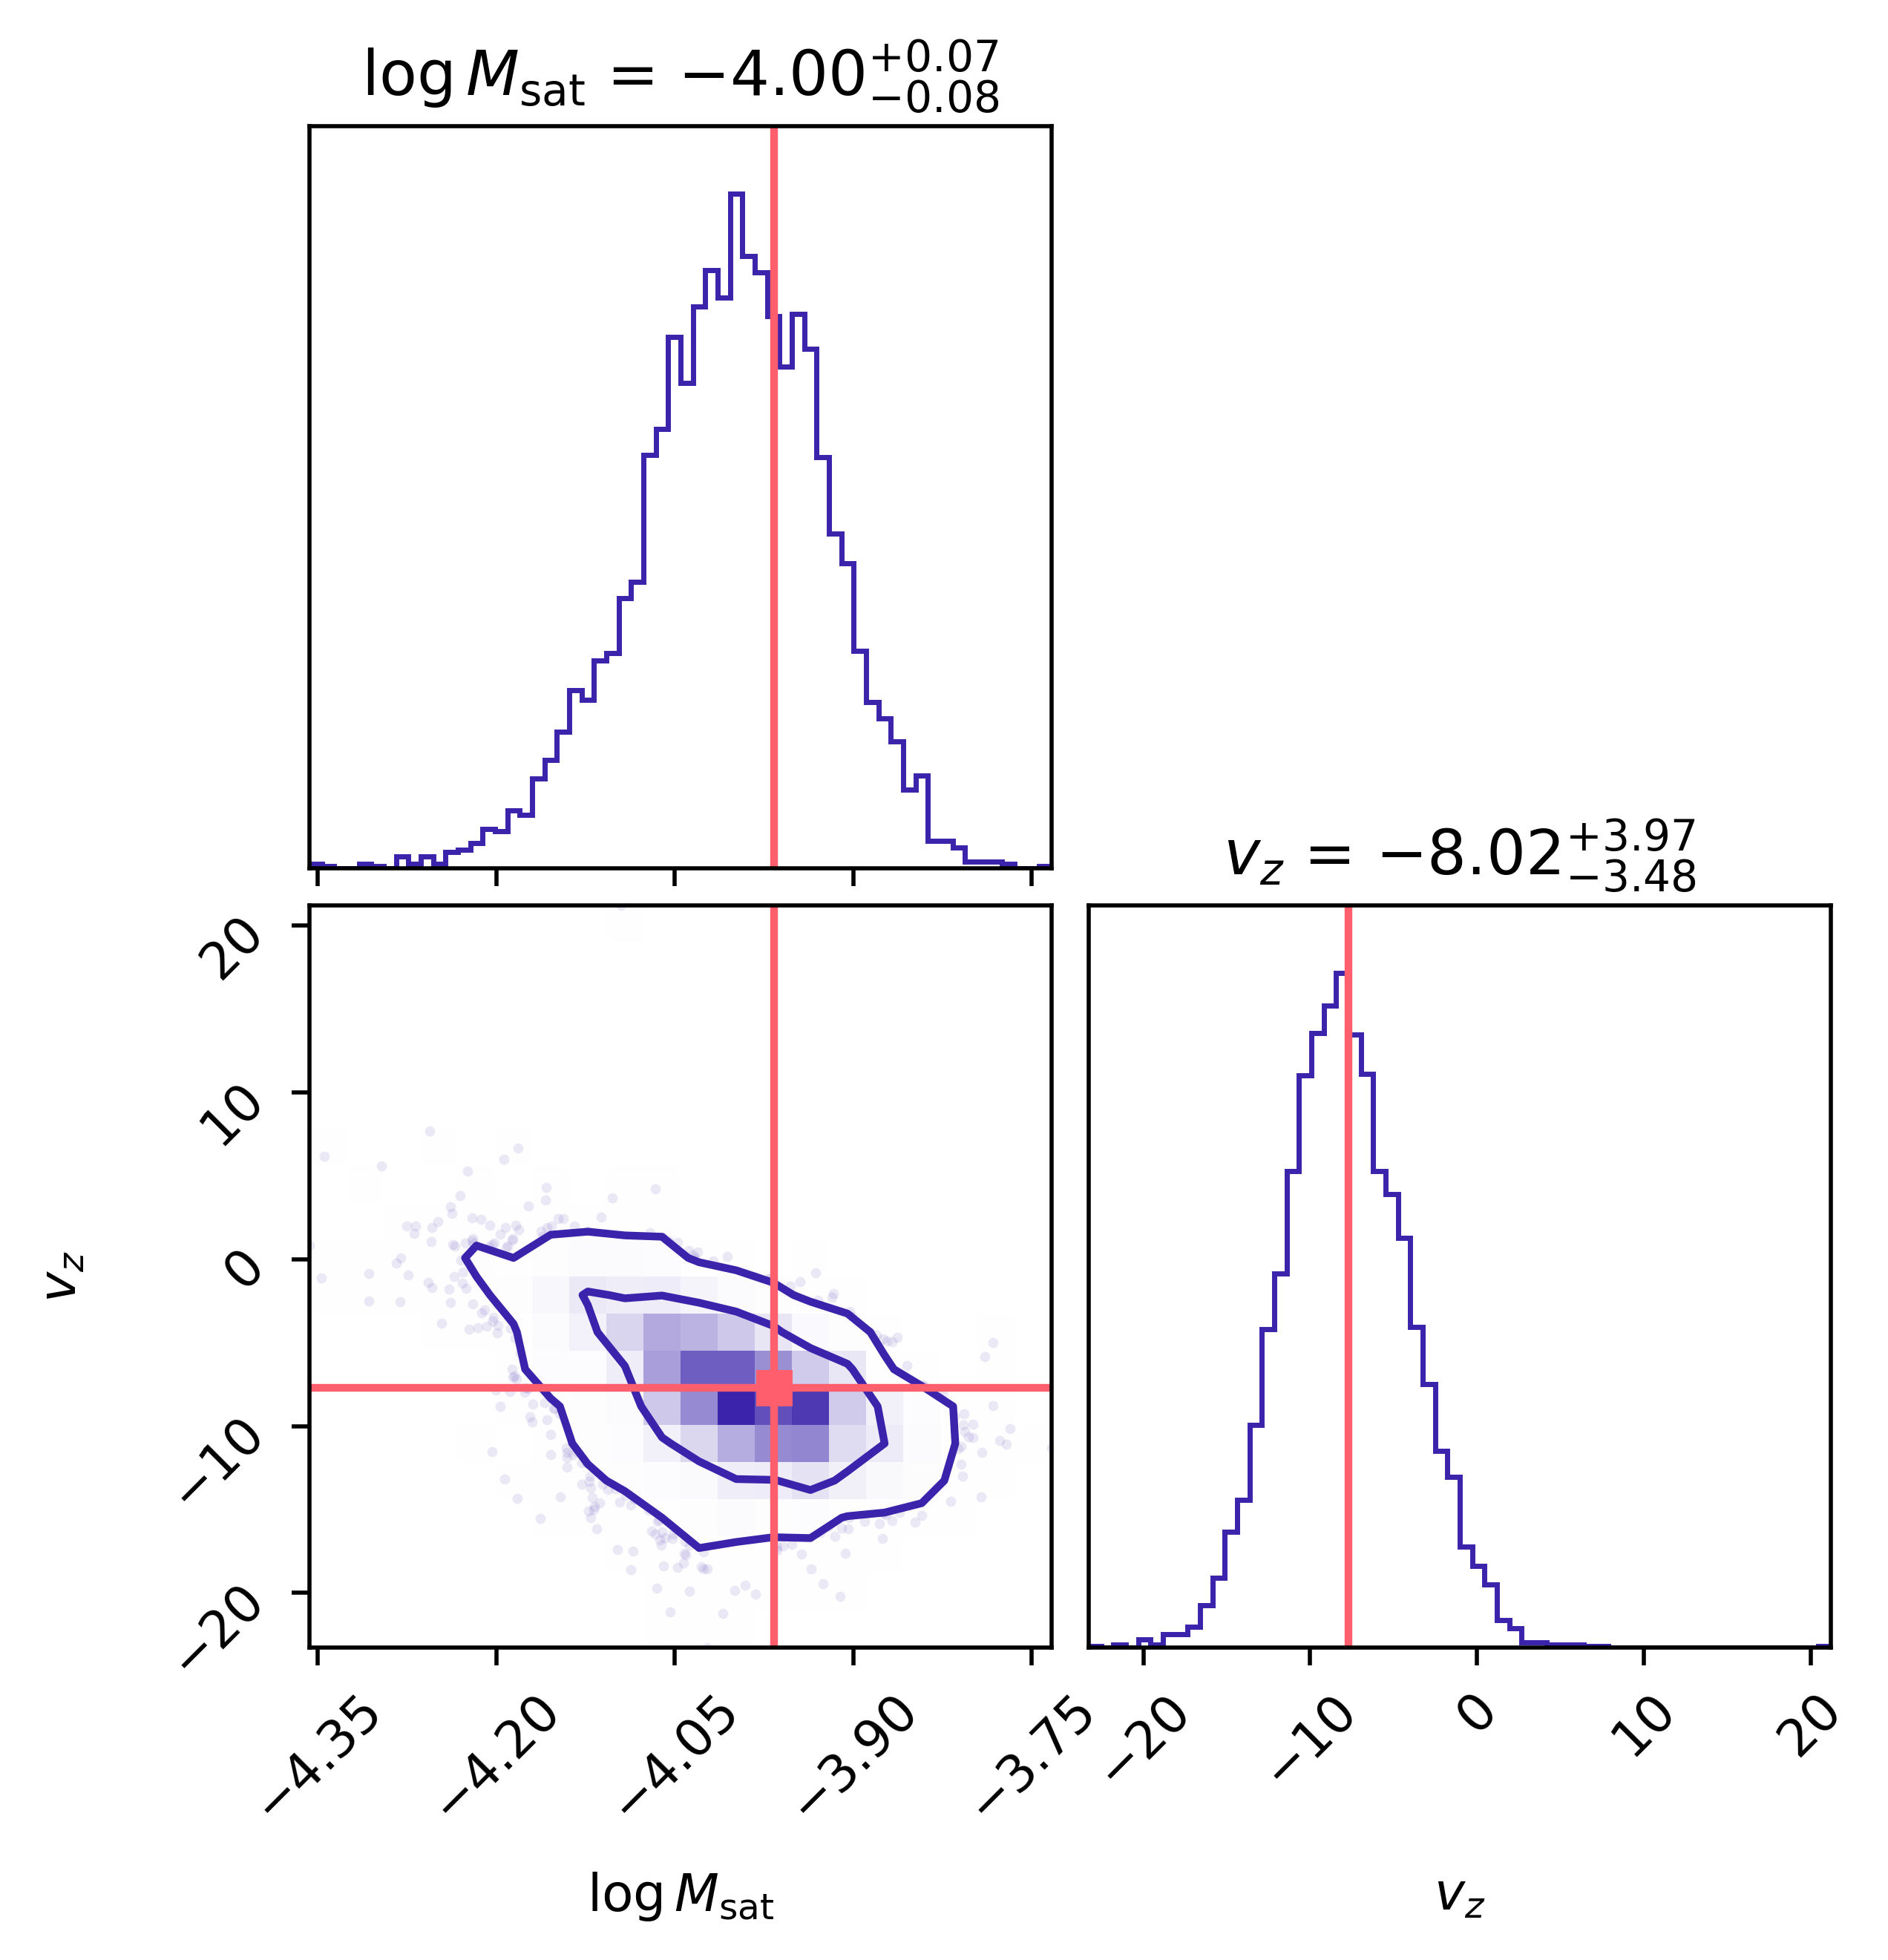

In [23]:
#corner plot
fig = corner.corner(
    samples[index],
    truths=labels[index],
    truth_color='#FF5E6D',
    levels=(0.68, 0.95),
    show_titles=True,
    labels=[r'$\log M_\mathrm{sat}$', r'$v_z$'],
    title_kwargs={"fontsize": 12},
    plot_contours=True,
    color='#3B23AB',
    hist_bin_factor = 3
)

plt.rcParams['figure.dpi'] = 500
plt.show()

These two functions help find the confidence interval of posteriors, and calcualte the coverage given truth.

In [16]:
def find_confidence_inverval(posteriors, confidence_level):
    lower_percent = (100 - confidence_level) / 2
    lower = np.percentile(posteriors, lower_percent, axis=1)
    upper_percent = 100 - (100 - confidence_level) / 2
    upper = np.percentile(posteriors, upper_percent, axis=1)
    return (lower, upper)

def calculate_coverage(truths, posteriors, confidence_level_list):
    '''
    Return coverage of the given posteriors
    '''
    coverage = list()
    for cl in confidence_level_list:
        lower, upper = find_confidence_inverval(posteriors, cl)
        percent = np.mean((lower < truths) & (truths < upper))
        coverage.append(percent)
    coverage = np.array(coverage)
    return coverage

For example, if we want to make a coverage plot for vz and msat:


1.   specify a list of level of confidence:









In [17]:
confidence_level_list = np.linspace(5, 95, 19)

2.   calculate the corresponding coverage for each parameter.
notice that `labels` is a list of string represents the parameters we used for regression; `samples` is an array of samples we draw from the model, where `samples[0]` is the first stream in the sample, and `samples[0][0]` returns the `msat` of `stream_0`


In [18]:
coverages = []
for i in range(2):
     coverage = calculate_coverage(labels[..., i], samples[..., i], confidence_level_list)
     coverages.append(coverage)

msat, vz = np.array(coverages)

3. coverage plot

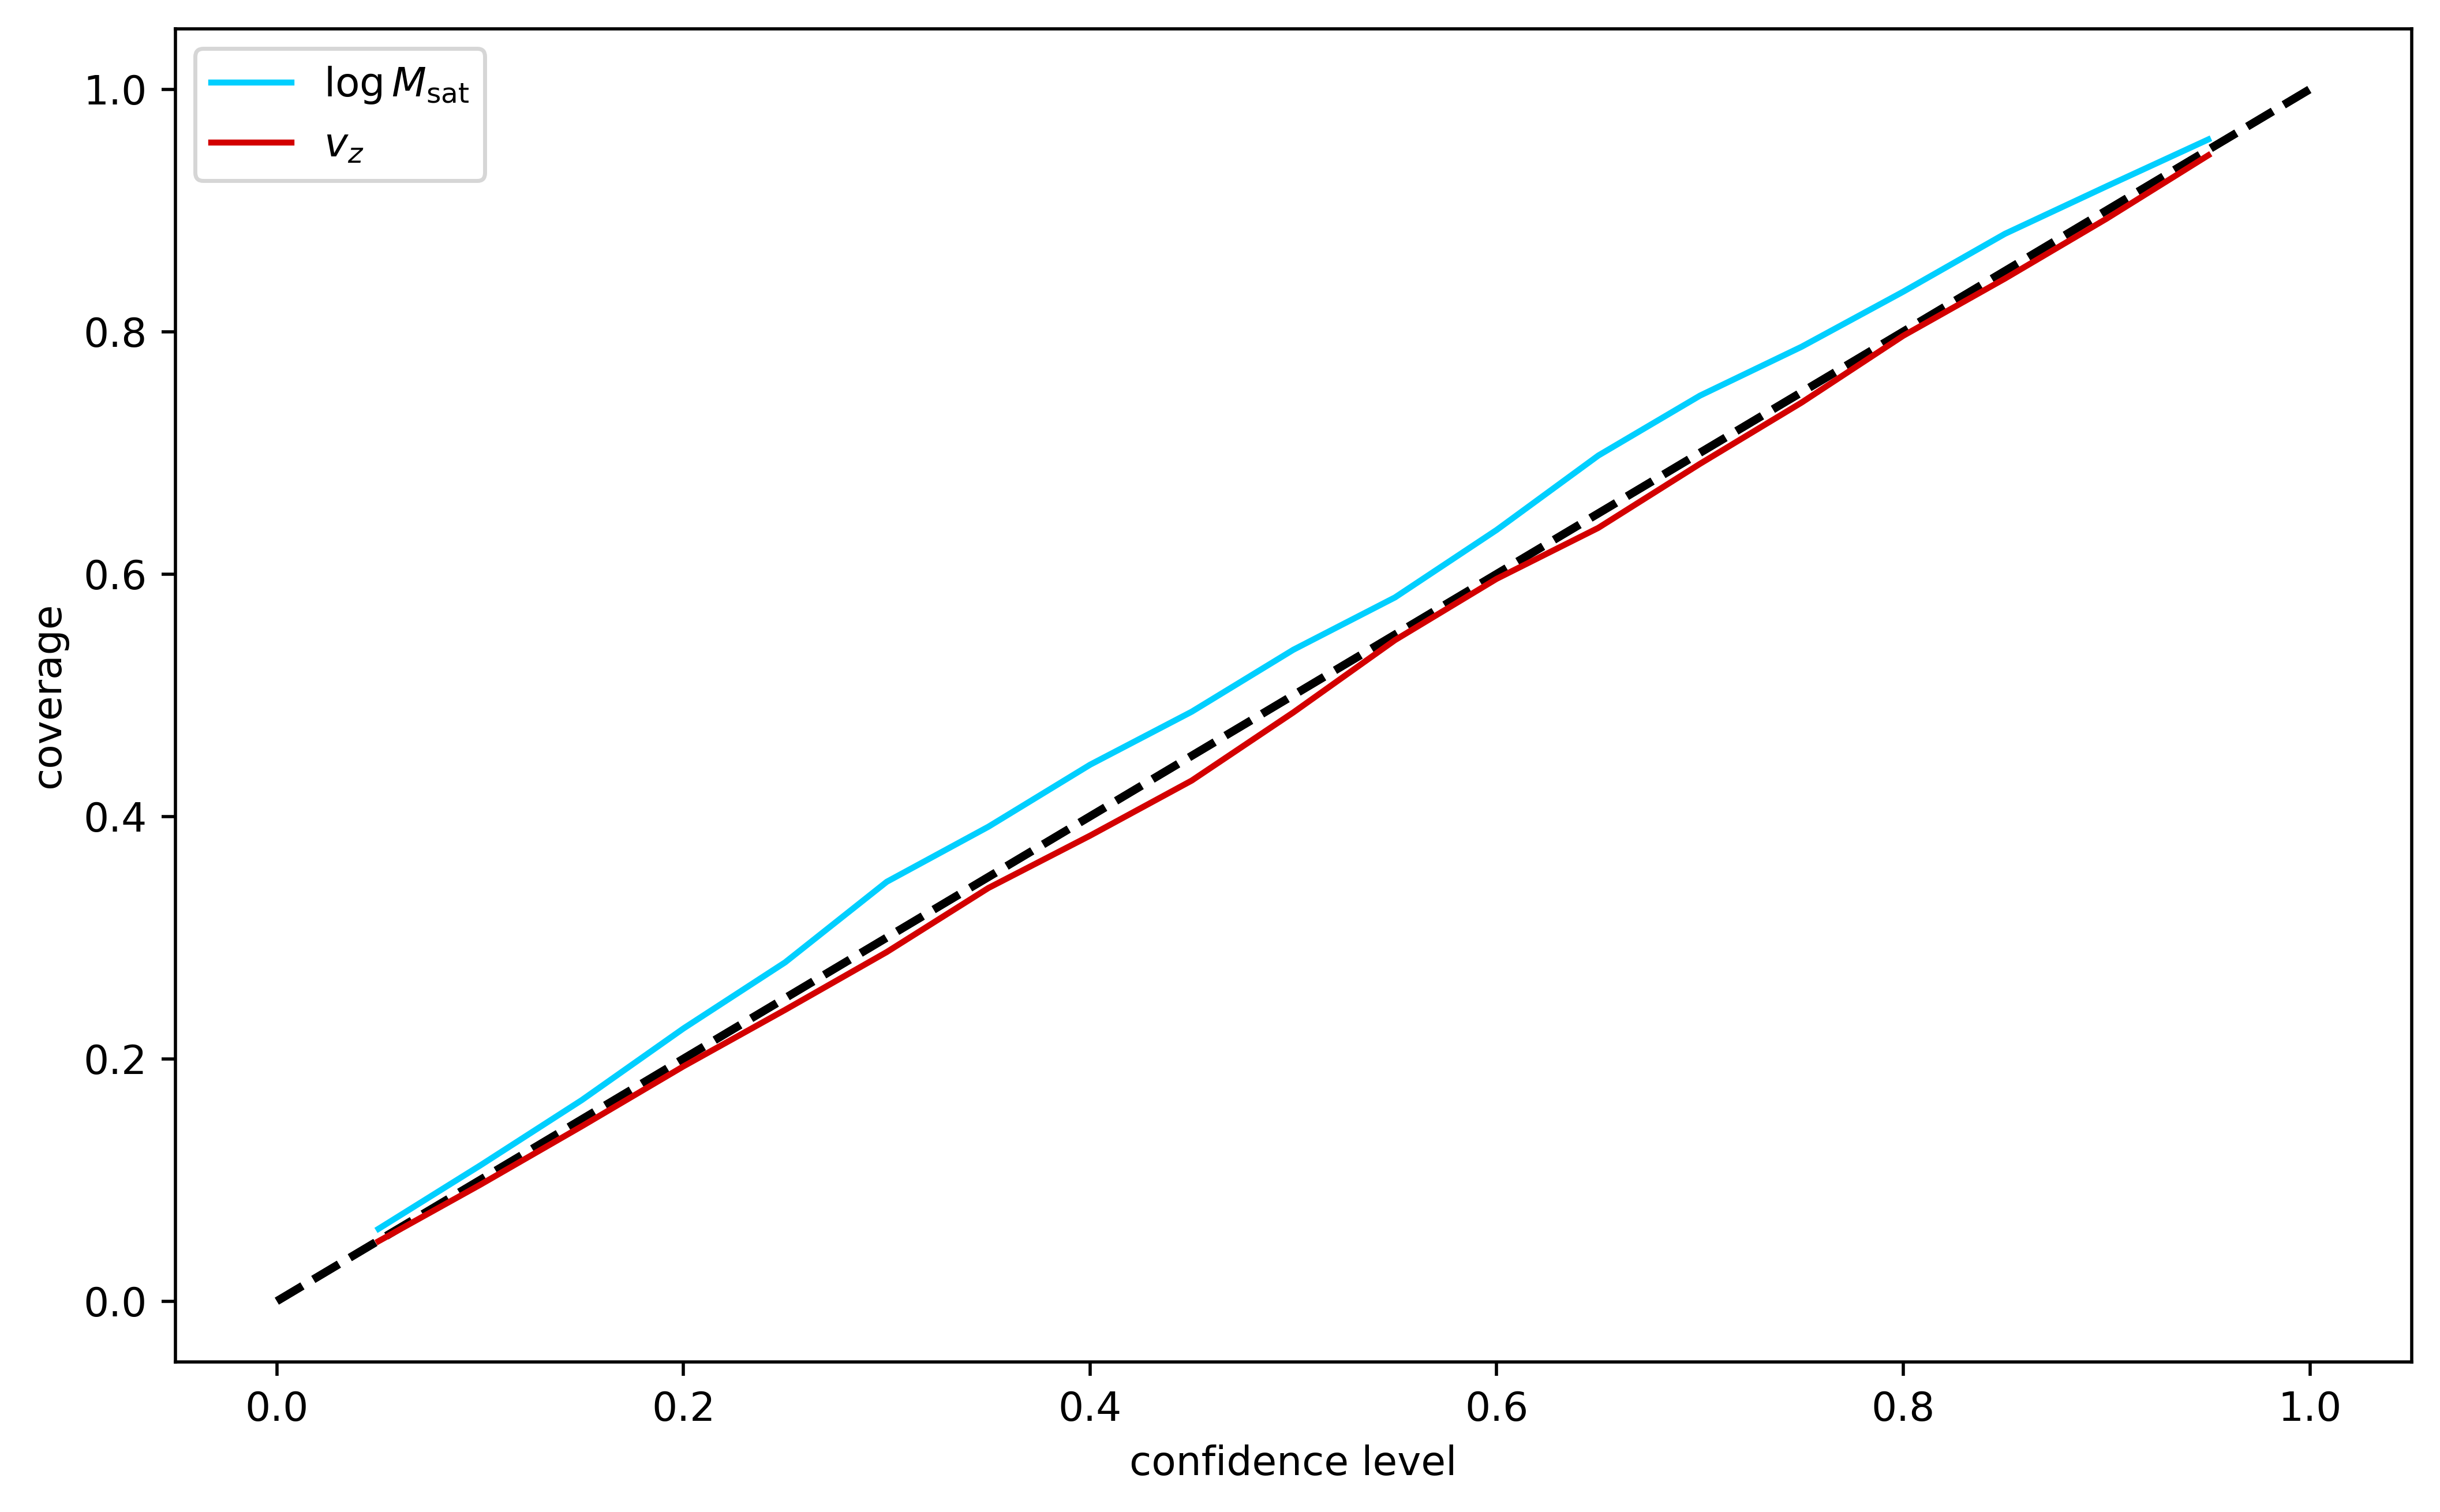

In [19]:
plt.figure(figsize=(10, 6))
plt.plot([(0, 0), (1, 1)], color='black', linestyle='--', linewidth=2)
plt.plot(confidence_level_list/100, msat, label=r'$\log M_\mathrm{sat}$', color = '#00CFFF')
plt.plot(confidence_level_list/100, vz, label=r'$v_z$', color = '#D30000')
plt.xlabel('confidence level')
plt.ylabel('coverage')
plt.legend()
plt.show()

This following function helps calculate and plot the predicted posteriors vs. truths. For example, we use medians of the predicted posteriors `msat`, `vz` given by model.

In [20]:
def predicted_vs_true(p, t, num_bins=10):
    '''calcaulate predicted vs true posterior,
    return bin_centers, median, error, standard deviation

    Parameters:
    ----------
    p: a list of predicted posteriors
    t: a list of true posteriors
    num_bins: number of bins on t
    '''
    bin_edges = np.linspace(t.min(), t.max(), num_bins+1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    p_median = np.zeros(num_bins)
    p_stdv = np.zeros(num_bins)
    p_count = np.zeros(num_bins)
    for i in range(num_bins):
        mask = (t >= bin_edges[i]) & (t <= bin_edges[i + 1])
        if mask.sum() <= 1:
            continue
        p_median[i] = p[mask].mean(axis=0)
        p_stdv[i] = p[mask].std(axis=0)
        p_count[i] = mask.sum()
    p_error = p_stdv / (p_count)**0.5
    return bin_centers, p_median, p_error, p_stdv

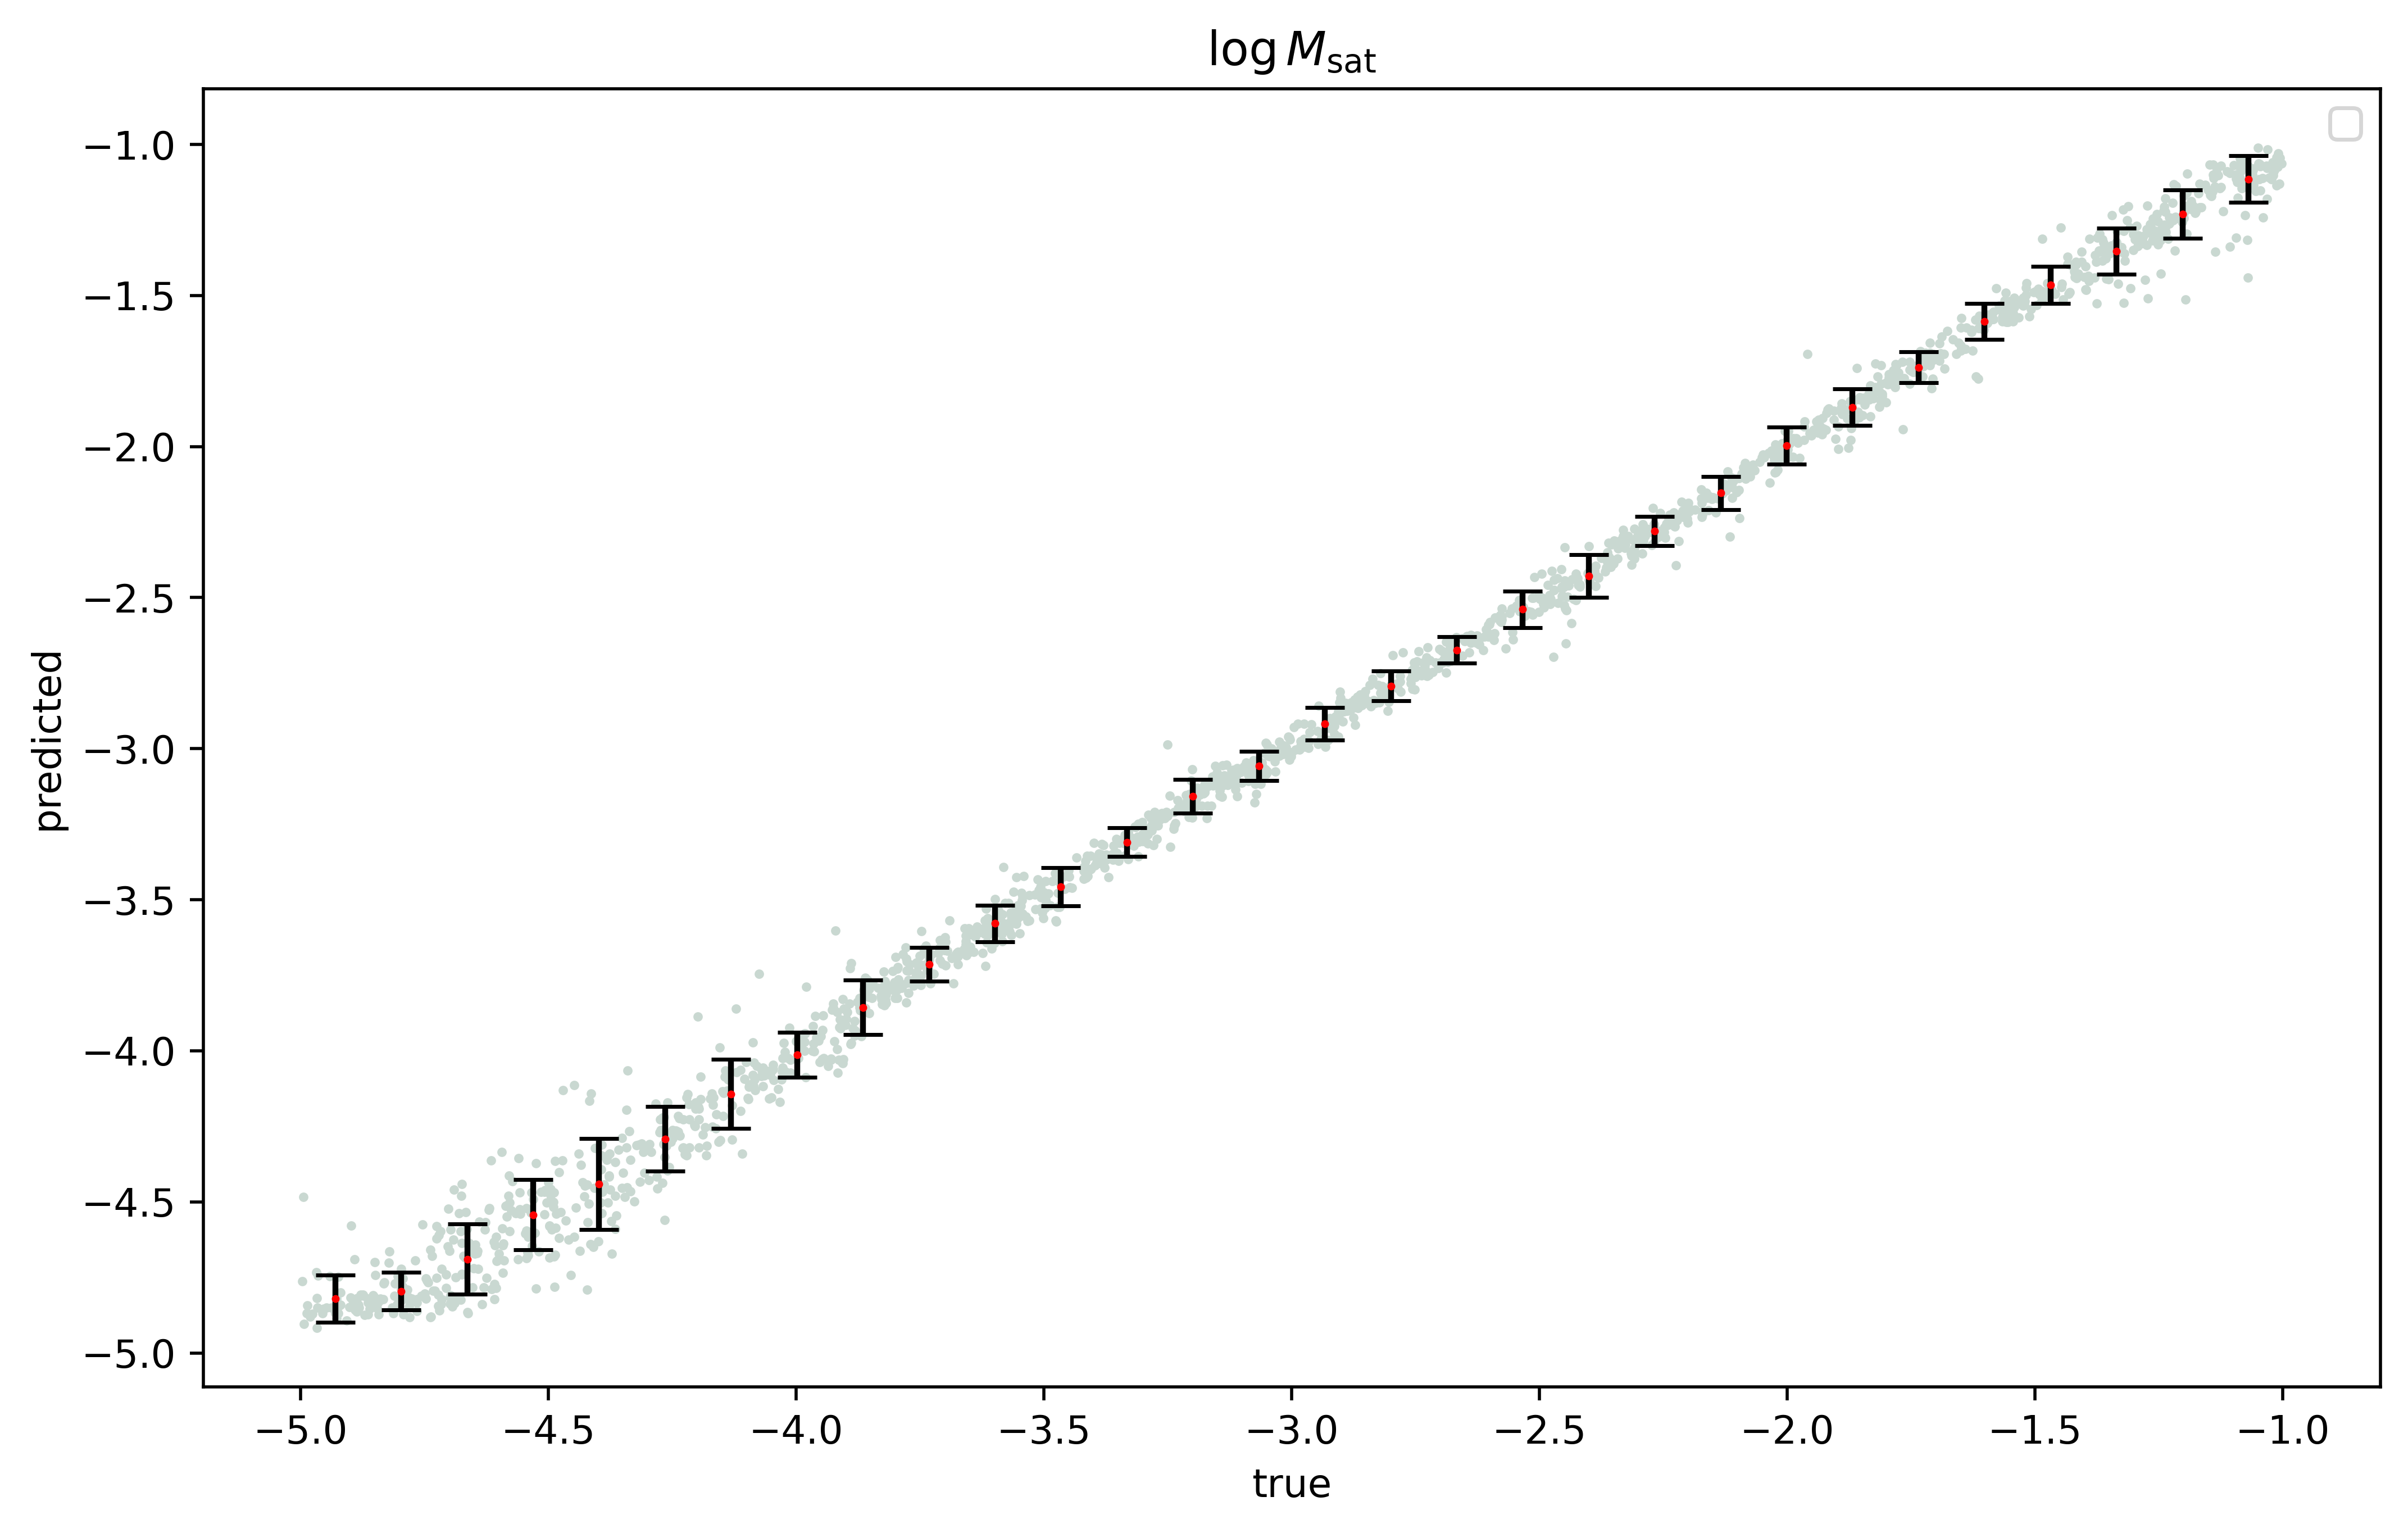

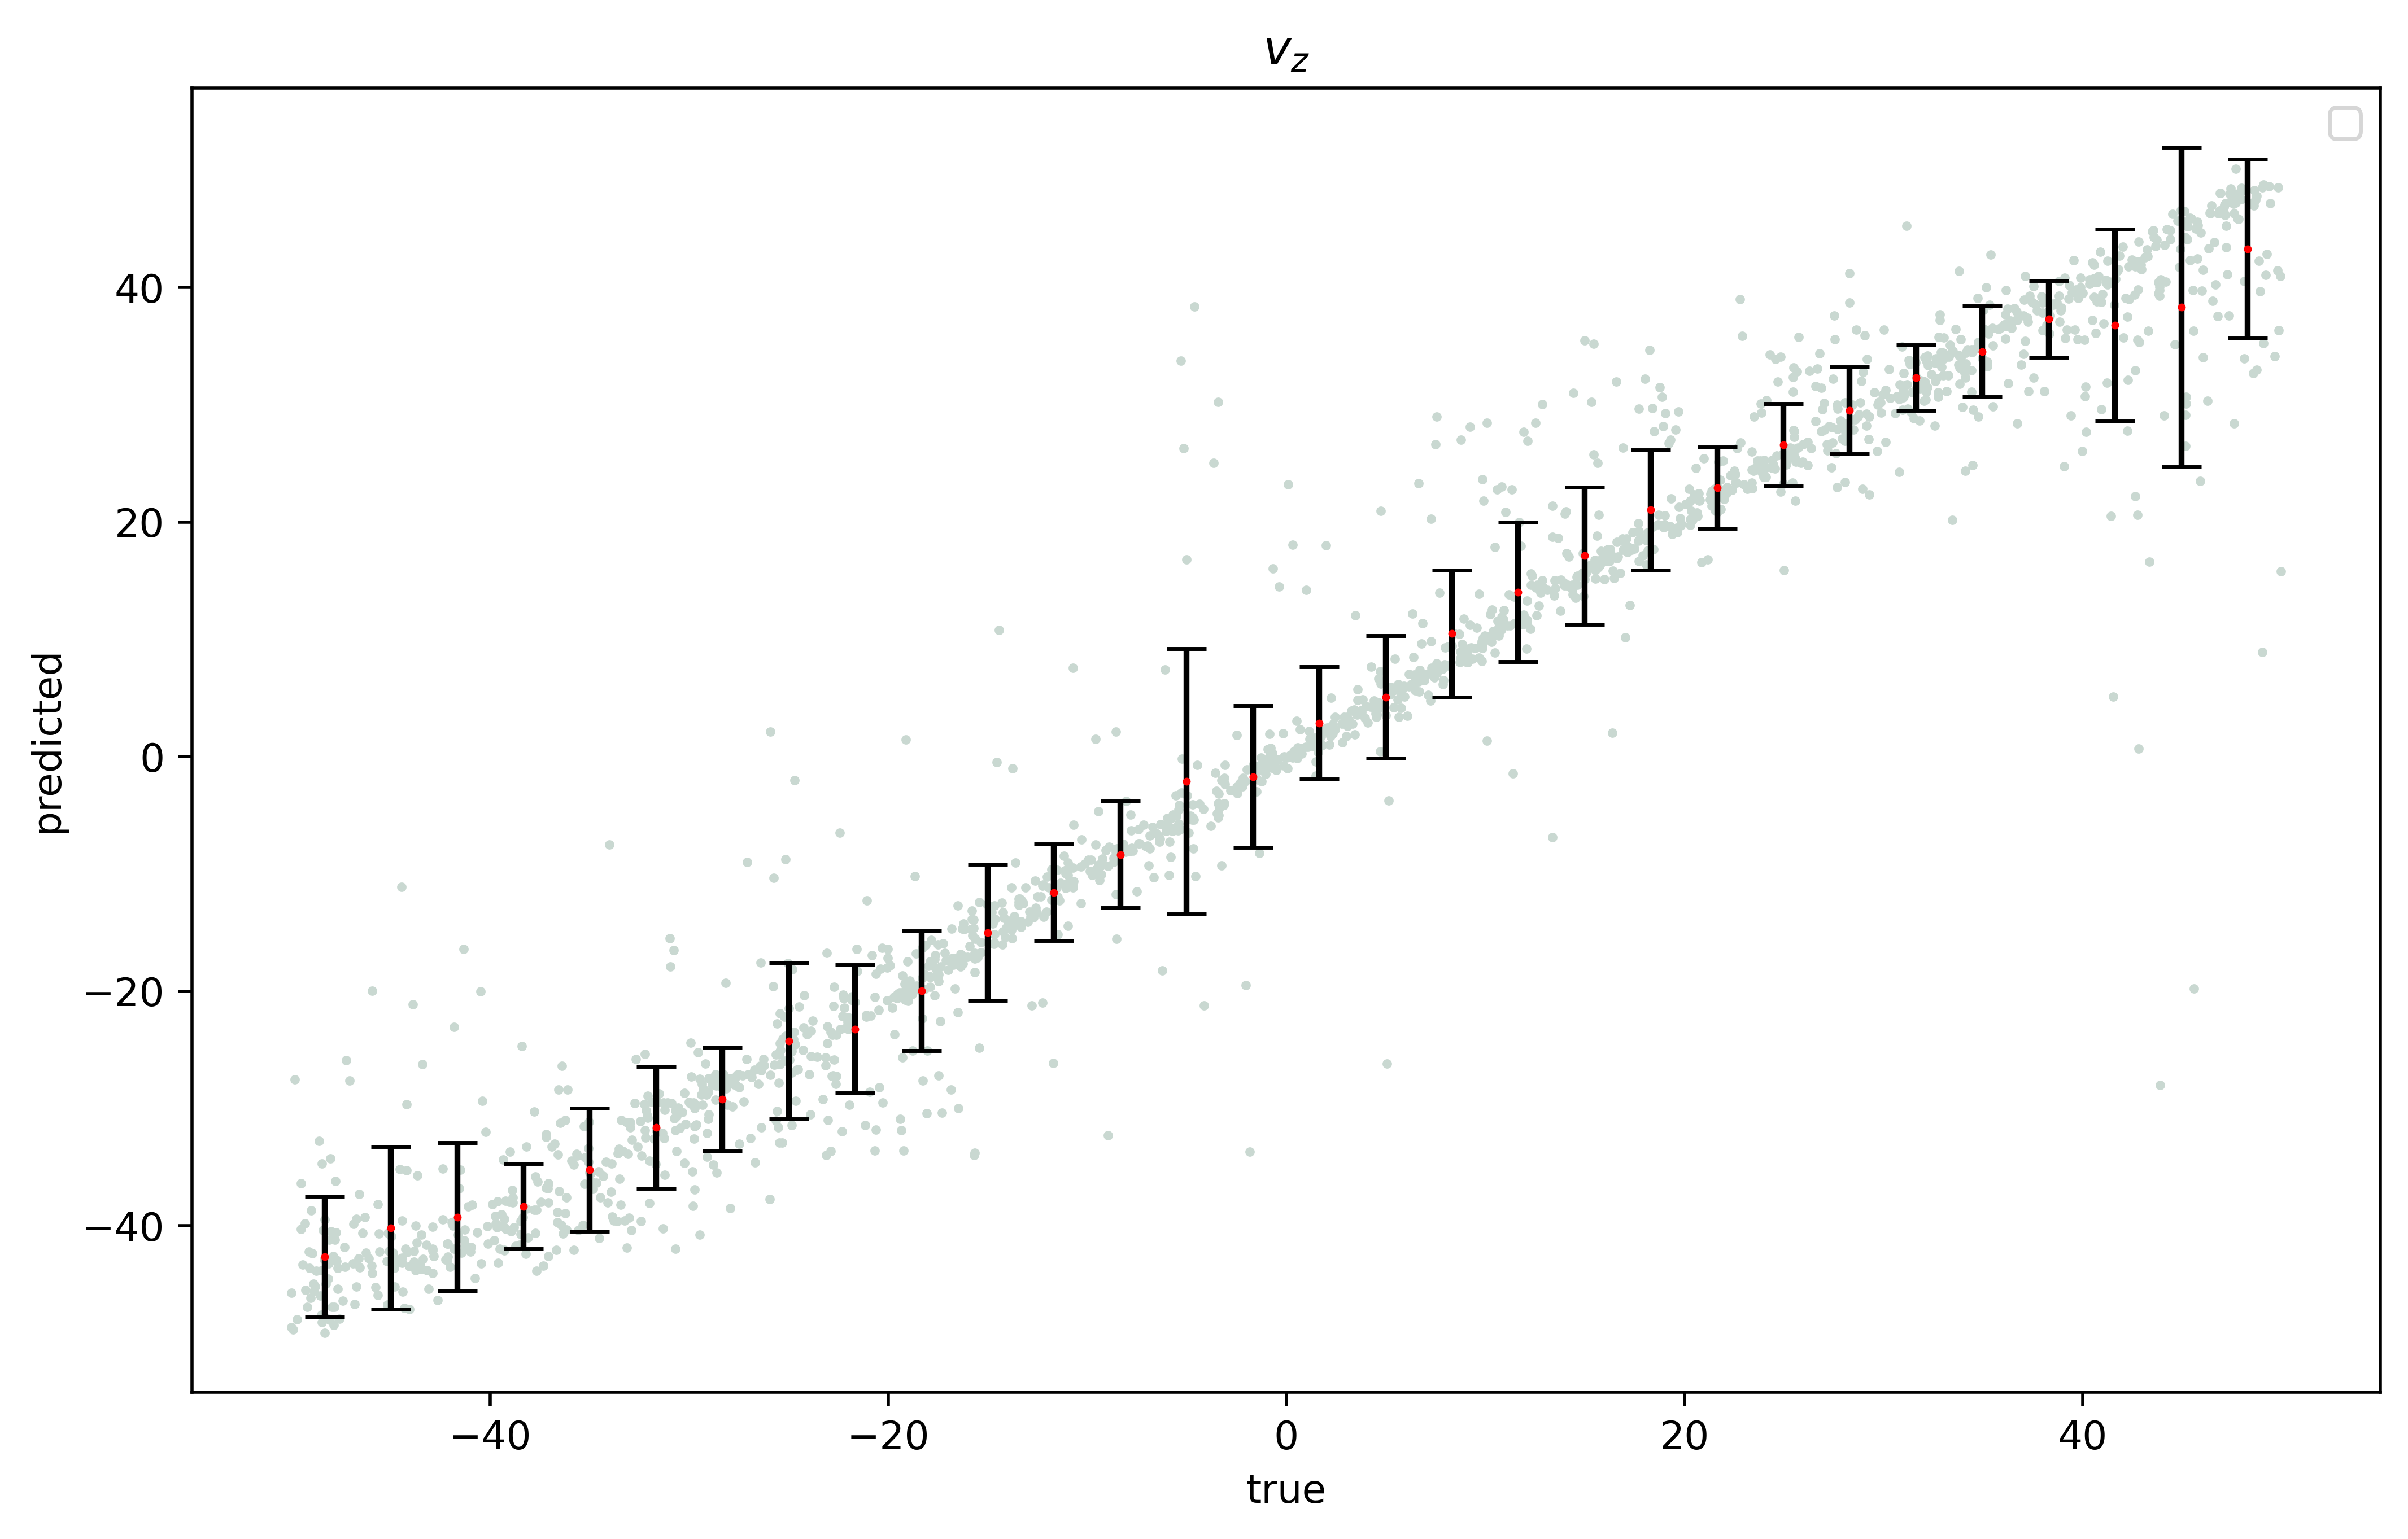

In [21]:
# plot predicted values (median) vs true values
def find_posterior_medians(posteriors):
     return [np.median(posterior) for posterior in posteriors]

predicted = []
for i in range(2):
     predicted.append(find_posterior_medians(samples[..., i]))

msat_predicted, vz_predicted = np.array(predicted)
msat_true = labels[..., 0]
vz_true = labels[..., 1]

'Notice that num_bins here is not the same as num_bins in model. You can vary this value to make better plots.'
msat_centers, msat_median, msat_error, msat_stdv = predicted_vs_true(msat_predicted, msat_true, num_bins=30)
vz_centers, vz_median, vz_error, vz_stdv = predicted_vs_true(vz_predicted, vz_true, num_bins=30)

'msat'
plt.figure(figsize=(10, 6))
plt.scatter(msat_true, msat_predicted, s=2, color='#C9D8D1')
plt.errorbar(msat_centers, msat_median, yerr=msat_stdv, fmt='o', color='red', markersize=1, ecolor='black', capsize=5)
plt.title(r'$\log M_\mathrm{sat}$')
plt.xlabel('true')
plt.ylabel('predicted')
plt.legend()
plt.show()

'vz'
plt.figure(figsize=(10, 6))
plt.scatter(vz_true, vz_predicted, s=2, color='#C9D8D1')
plt.errorbar(vz_centers, vz_median, yerr=vz_stdv, fmt='o', color='red', markersize=1, ecolor='black', capsize=5)
plt.title(r'$v_z$')
plt.xlabel('true')
plt.ylabel('predicted')
plt.legend()
plt.show()